In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# 데이터 분포 확인을 위한 plt 라이브러리 import 
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

In [11]:
## 주문 + 리뷰
df = orders.merge(
    reviews[["order_id", "review_score"]],
    on="order_id",
    how="left"
)

In [12]:
## 주문 + 판매자 + 상품
df = df.merge(
        order_items[["order_id", "seller_id", "product_id"]],
        on="order_id",
        how="left"
)

In [13]:
## 날짜형 변수 변환
date_cols = [
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [ ]:
## 배송 관련 파생 변수

# 배송지연일
df["delivery_delay_days"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

# 출고까지 걸린 기간
df["processing_days"] = (
    df["order_delivered_carrier_date"] - df["order_approved_at"]
).dt.days

# 운송 기간
df["shipping_days"] = (
    df["order_delivered_customer_date"] - df["order_delivered_carrier_date"]
).dt.days

In [ ]:
# 출고 지연 여부 (정상 출고: 0 / 지연: 1)
#df["shipment_delayed"] = (df["processing_days"] > 2).astype(int)

# 부정리뷰 여부 (긍정(4~5): 0 / 부정(1~3점): 1)
#df["negative_review"] = (df["review_score"] <= 3).astype(int)

In [37]:
## 출고-배달 흐름 이상
df_clean = df[
    (df["processing_days"] >= 0) &
    (df["shipping_days"] >= 0)
]
df_clean.shape

(109229, 14)

In [38]:
seller_summary = (
    df_clean.groupby("seller_id")
    .agg(
        total_orders=("order_id", "count"),
        avg_review_score=("review_score", "mean"),
        avg_processing_days=("processing_days", "mean"),
        avg_shipping_days=("shipping_days", "mean"),         # 해당 판매자가 처리한 전체 주문 중, 출고 지연된 주문의 비율
        #shipment_delay_ratio=("shipment_delayed", "mean"),   # 해당 판매자가 처리한 전체 주문 중, 배송 지연된 주문의 비율
        avg_delivery_delay=("delivery_delay_days", "mean")        # 판매자별 평균 배송지연일
    )
    .reset_index()
)

seller_summary.head()


,seller_id,total_orders,avg_review_score,avg_processing_days,avg_shipping_days,avg_delivery_delay
0,0015a82c2db000af6aaaf3ae2ecb0532,3,3.666667,2.333333,7.333333,-16.333333
1,001cca7ae9ae17fb1caed9dfb1094831,234,3.965368,1.683761,9.991453,-13.213675
2,002100f778ceb8431b7a1020ff7ab48f,55,4.036364,2.981818,10.963636,-8.218182
3,003554e2dce176b5555353e4f3555ac8,1,5.000000,0.000000,4.000000,-27.000000
4,004c9cd9d87a3c30c522c48c4fc07416,173,4.152047,0.936416,12.578035,-11.566474


In [39]:
##
seller_summary.describe()

,total_orders,avg_review_score,avg_processing_days,avg_shipping_days,avg_delivery_delay
count,2959.000000,2954.000000,2959.000000,2959.000000,2959.000000
mean,36.914160,4.151335,2.762889,8.107708,-12.204532
std,119.281212,0.798343,3.874951,5.746063,8.001168
min,1.000000,1.000000,0.000000,0.000000,-66.000000
25%,2.000000,3.888889,1.000000,5.166667,-15.333333
50%,8.000000,4.272727,1.730769,7.500000,-11.967742
75%,25.000000,4.714286,3.108515,10.000000,-9.000000
max,1955.000000,5.000000,61.000000,186.000000,167.000000


## 카테고리별

In [41]:
## 카테고리 정보 추가

products = pd.read_csv("olist_products_dataset.csv")

df_ctg = df_clean.merge(
    products[["product_id", "product_category_name"]],
    on="product_id",
    how="left"
)


In [42]:
category_seller_summary = (
    df_ctg.groupby(["product_category_name", "seller_id"])
    .agg(
        total_orders=("order_id", "count"),
        avg_review_score=("review_score", "mean"),
        avg_processing_days=("processing_days", "mean"),
        avg_shipping_days=("shipping_days", "mean"),         # 해당 판매자가 처리한 전체 주문 중, 출고 지연된 주문의 비율
        #shipment_delay_ratio=("shipment_delayed", "mean"),   # 해당 판매자가 처리한 전체 주문 중, 배송 지연된 주문의 비율
        avg_delivery_delay=("delivery_delay_days", "mean")        # 판매자별 평균 배송지연일
    )
    .reset_index()
)

In [44]:
category_seller_summary

,product_category_name,seller_id,total_orders,avg_review_score,avg_processing_days,avg_shipping_days,avg_delivery_delay
0,agro_industria_e_comercio,06579cb253ecd5a3a12a9e6eb6bf8f47,2,4.500000,1.000000,4.500000,-10.000000
1,agro_industria_e_comercio,0ed6ce5d87fd9c69eaacaeb778d67235,4,4.750000,5.750000,8.500000,-9.000000
2,agro_industria_e_comercio,2528744c5ef5d955adc318720a94d2e7,5,2.400000,2.400000,5.800000,-9.400000
3,agro_industria_e_comercio,269cff2d3c8d205c11f37a52402ea93b,4,4.250000,1.250000,5.500000,-9.250000
4,agro_industria_e_comercio,31ae0774c17fabd06ff707cc5bde005f,7,4.000000,1.142857,9.142857,-12.857143
...,...,...,...,...,...,...,...
6105,utilidades_domesticas,fe87f472055fbcf1d7e691c00b1560dc,6,4.500000,2.500000,2.166667,-3.000000
6106,utilidades_domesticas,febab0275244b9a49a623f0bd613ca2f,119,4.319328,0.789916,5.991597,-11.722689
6107,utilidades_domesticas,ffc470761de7d0232558ba5e786e57b7,10,3.800000,1.000000,6.000000,-14.800000
6108,utilidades_domesticas,ffdd9f82b9a447f6f8d4b91554cc7dd3,16,4.375000,3.937500,5.062500,-12.250000


In [48]:
## 카테고리별 배송관련 변수 평균내기
category_pivot = pd.pivot_table(
    category_seller_summary,
    index="product_category_name",
    values=[
        "avg_review_score",
        "avg_processing_days",
        "avg_shipping_days",
        "avg_delivery_delay"
    ],
    aggfunc="mean"
).reset_index()

category_pivot


,product_category_name,avg_delivery_delay,avg_processing_days,avg_review_score,avg_shipping_days
0,agro_industria_e_comercio,-11.214602,1.986128,3.997302,6.046076
1,alimentos,-11.209288,1.476892,4.378794,5.945827
2,alimentos_bebidas,-10.838980,2.231976,4.200629,7.428514
3,artes,-16.210075,1.920886,4.191623,8.010064
4,artes_e_artesanato,-7.743056,1.486111,4.409722,2.875000
...,...,...,...,...,...
68,sinalizacao_e_seguranca,-12.606575,1.830585,4.023939,7.702445
69,tablets_impressao_imagem,-13.250314,2.372117,3.863711,10.178302
70,telefonia,-11.477665,2.699530,3.992208,8.457298
71,telefonia_fixa,-13.235479,3.446840,3.800030,8.446683


In [50]:
category_pivot.describe()

,avg_delivery_delay,avg_processing_days,avg_review_score,avg_shipping_days
count,73.000000,73.000000,73.000000,73.000000
mean,-12.223341,2.538602,4.115352,8.004570
std,1.878736,0.999845,0.338679,1.545889
min,-17.000000,0.346154,2.500000,2.875000
25%,-12.822935,1.986128,3.997302,7.086126
50%,-12.083567,2.372117,4.104200,7.977492
75%,-11.307692,2.981818,4.295608,8.989444
max,-6.696970,5.373249,5.000000,13.000000


#### 조건별 seller_id 개수 집계

In [70]:
summary_df = pd.DataFrame({
    "condition": [
        "processing_days > 5",
        "shipping_days > 12"
    ],
    "seller_count": [
        df_clean.loc[df_clean["processing_days"] > 5, "seller_id"].nunique(),
        df_clean.loc[df_clean["shipping_days"] > 12, "seller_id"].nunique()
    ]
})

summary_df

,condition,seller_count
0,processing_days > 5,1200
1,shipping_days > 12,1809


In [71]:
## seller_id별 processing_days >= 5 주문 건수
processing_count_by_seller = (
    df[df["processing_days"] >= 5]
    .groupby("seller_id")
    .size()
    .reset_index(name="processing_days_up_5_cnt")
    .sort_values("processing_days_up_5_cnt", ascending=False)
)

processing_count_by_seller

,seller_id,processing_days_up_5_cnt
732,7c67e1448b00f6e969d365cea6b010ab,1268
188,1f50f920176fa81dab994f9023523100,454
94,1025f0e2d44d7041d6cf58b6550e0bfa,319
795,85d9eb9ddc5d00ca9336a2219c97bb13,273
361,3d871de0142ce09b7081e2b9d1733cb1,255
...,...,...
980,a4fc6eadaff1576af888509a53420f6a,1
979,a4bd6e9adf39b63f43dc545d3ca1f53d,1
977,a478c7961d6a992065b24e63b366f90b,1
1002,aae5953b9edddf14749c0d65d60eb4b9,1


In [72]:
## seller_id별 shipping_days >= 14 주문 건수
shipping_count_by_seller = (
    df[df["shipping_days"] >= 12]
    .groupby("seller_id")
    .size()
    .reset_index(name="shipping_days_up_12_cnt")
    .sort_values("shipping_days_up_12_cnt", ascending=False)
)

shipping_count_by_seller

,seller_id,shipping_days_up_12_cnt
241,1f50f920176fa81dab994f9023523100,747
551,4a3ca9315b744ce9f8e9374361493884,679
540,4869f7a5dfa277a7dca6462dcf3b52b2,439
1530,cc419e0650a3c5ba77189a1882b7556a,430
955,7c67e1448b00f6e969d365cea6b010ab,397
...,...,...
29,039e6ad9dae79614493083e241147386,1
28,039b29ff3b3473435d0cd59040575de9,1
27,038b75b729c8a9a04b0d07cba7eabe86,1
26,0307f7565ff85b299b6e5ef162b1b1a9,1


In [73]:
## 두 결과 합쳐서 보기
seller_delay_counts = processing_count_by_seller.merge(
    shipping_count_by_seller,
    on="seller_id",
    how="outer"
).fillna(0)

seller_delay_counts

,seller_id,processing_days_up_5_cnt,shipping_days_up_12_cnt
0,0015a82c2db000af6aaaf3ae2ecb0532,1.0,0.0
1,001cca7ae9ae17fb1caed9dfb1094831,17.0,56.0
2,002100f778ceb8431b7a1020ff7ab48f,9.0,19.0
3,004c9cd9d87a3c30c522c48c4fc07416,0.0,73.0
4,00720abe85ba0859807595bbf045a33b,2.0,3.0
...,...,...,...
2225,ffc470761de7d0232558ba5e786e57b7,0.0,6.0
2226,ffdd9f82b9a447f6f8d4b91554cc7dd3,8.0,2.0
2227,ffeee66ac5d5a62fe688b9d26f83f534,4.0,5.0
2228,fffd5413c0700ac820c7069d66d98c89,2.0,22.0


In [74]:
## 주문 수 대비 비율
total_orders_by_seller = (
    df.groupby("seller_id")
    .size()
    .reset_index(name="total_orders")
)

seller_delay_counts = seller_delay_counts.merge(
    total_orders_by_seller,
    on="seller_id",
    how="left"
)

seller_delay_counts["processing_up_5_ratio"] = (
    seller_delay_counts["processing_days_up_5_cnt"] /
    seller_delay_counts["total_orders"]
)

seller_delay_counts["shipping_up_12_ratio"] = (
    seller_delay_counts["shipping_days_up_12_cnt"] /
    seller_delay_counts["total_orders"]
)

seller_delay_counts

,seller_id,processing_days_up_5_cnt,shipping_days_up_12_cnt,total_orders,processing_up_5_ratio,shipping_up_12_ratio
0,0015a82c2db000af6aaaf3ae2ecb0532,1.0,0.0,3,0.333333,0.000000
1,001cca7ae9ae17fb1caed9dfb1094831,17.0,56.0,239,0.071130,0.234310
2,002100f778ceb8431b7a1020ff7ab48f,9.0,19.0,56,0.160714,0.339286
3,004c9cd9d87a3c30c522c48c4fc07416,0.0,73.0,176,0.000000,0.414773
4,00720abe85ba0859807595bbf045a33b,2.0,3.0,26,0.076923,0.115385
...,...,...,...,...,...,...
2225,ffc470761de7d0232558ba5e786e57b7,0.0,6.0,31,0.000000,0.193548
2226,ffdd9f82b9a447f6f8d4b91554cc7dd3,8.0,2.0,20,0.400000,0.100000
2227,ffeee66ac5d5a62fe688b9d26f83f534,4.0,5.0,14,0.285714,0.357143
2228,fffd5413c0700ac820c7069d66d98c89,2.0,22.0,61,0.032787,0.360656


In [75]:
seller_delay_counts.describe()

,processing_days_up_5_cnt,shipping_days_up_12_cnt,total_orders,processing_up_5_ratio,shipping_up_12_ratio
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000
mean,7.565022,12.215247,49.573991,0.221735,0.265974
std,35.108216,39.191348,139.372202,0.289069,0.232413
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,5.000000,0.000000,0.111111
50%,1.000000,3.000000,13.000000,0.090909,0.222222
75%,4.000000,9.000000,40.000000,0.333333,0.333333
max,1268.000000,747.000000,2039.000000,1.000000,1.000000


In [76]:
## processing_up_5_ratio : 75p * 1.5 = 0.54
q1 = seller_delay_counts["processing_up_5_ratio"].quantile(0.25)
q3 = seller_delay_counts["processing_up_5_ratio"].quantile(0.75)

iqr = q3 - q1

threshold = q3 + 1.5 * iqr

outlier_seller_count = (
    seller_delay_counts[
        seller_delay_counts["processing_up_5_ratio"] > threshold
    ]["seller_id"]
    .nunique()
)

outlier_seller_count

163

#### 시각화

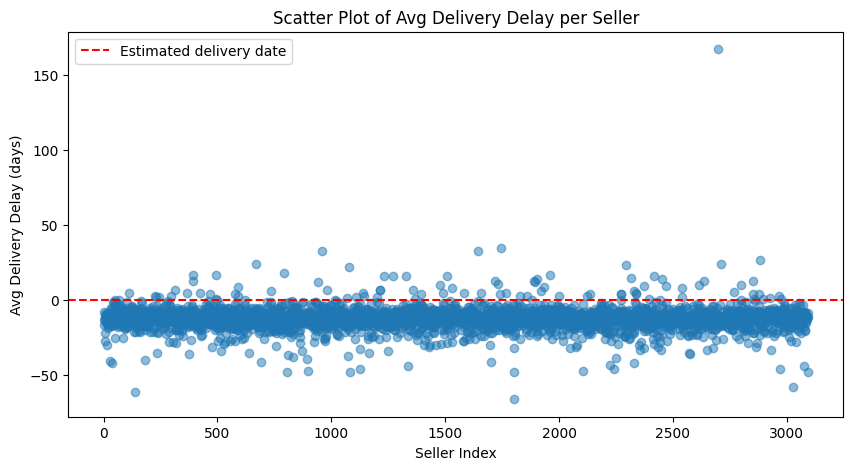

In [30]:
## 판매자별 평균 배송지연 분포
plt.figure(figsize=(10,5))
plt.scatter(
    x=range(len(seller_summary)),
    y=seller_summary["avg_delivery_delay"],
    alpha=0.5
)
plt.axhline(0, color="red", linestyle="--", label="Estimated delivery date")
plt.title("Scatter Plot of Avg Delivery Delay per Seller")
plt.xlabel("Seller Index")
plt.ylabel("Avg Delivery Delay (days)")
plt.legend()
plt.show()

#### 일단 흐름 이상한 것까지만 거르고, 출고일 계산
#### 이후로는 결측 관련 eda 진행

In [20]:
df_clean["delivery_completed"] = df_clean["delivery_delay_days"].notna().astype(int)
df2 = df_clean[df_clean["delivery_completed"] == 1].copy()
df2.shape

C:\Users\puppk\AppData\Local\Temp\ipykernel_19020\444513443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["delivery_completed"] = df_clean["delivery_delay_days"].notna().astype(int)


(110838, 15)

In [21]:
df2.isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                 15
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date      0
review_score                     827
seller_id                          0
product_id                         0
delivery_delay_days                0
processing_days                   15
shipping_days                      0
delivery_completed                 0
dtype: int64

In [23]:
df2['order_status'].unique()

array(['delivered', 'canceled'], dtype=object)

In [ ]:
## 같은 주문 id 2개 이상인 데이터 뽑기
df['order_id'].value_counts()[lambda x: x >= 2]

In [ ]:
## 배송 지연 변수 생성
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [ ]:
df["delivery_delay_days"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

df["is_late"] = (df["delivery_delay_days"] > 0).astype(int)


In [ ]:
## 저평점 정의
df["low_review"] = (df["review_score"] <= 2).astype(int)

In [ ]:
df.isna().sum()

In [ ]:
df["delivery_completed"] = df["delivery_delay_days"].notna().astype(int)
df2 = df[df["delivery_completed"] == 1].copy()
df2 = df2[df2["review_score"].notna()]
df2.isna().sum()


In [ ]:
df["delivery_completed"].unique()

In [ ]:
df2.dropna(inplace=True)

In [ ]:
## 배송 지연 분포
sns.histplot(df2["delivery_delay_days"].dropna(), bins=50)
plt.axvline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days Distribution")
plt.show()

In [8]:
## 상품 접수가 다른 날보다 뒤쳐진 경우 --> 이상치
mask = (
    (df["order_approved_at"] > df["order_purchase_timestamp"]) |
    (df["order_approved_at"] > df["order_delivered_carrier_date"]) |
    (df["order_approved_at"] > df["order_delivered_customer_date"]) |
    (df["order_approved_at"] > df["order_estimated_delivery_date"])
)

delayed_rows = df[mask]
delayed_rows

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,n_items,n_sellers,total_price,total_freight,payment_type,n_payments,total_payment
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,4.0,1.0,1.0,29.99,8.72,voucher,3.0,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,4.0,1.0,1.0,118.70,22.76,boleto,1.0,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,5.0,1.0,1.0,159.90,19.22,credit_card,1.0,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,5.0,1.0,1.0,45.00,27.20,credit_card,1.0,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,5.0,1.0,1.0,19.90,8.72,credit_card,1.0,28.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22 00:00:00,5.0,1.0,1.0,139.90,16.09,credit_card,1.0,155.99
99988,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,4.0,1.0,1.0,174.90,20.10,credit_card,1.0,195.00
99989,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,5.0,1.0,1.0,205.99,65.02,credit_card,1.0,271.01
99990,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,2.0,1.0,359.98,81.18,credit_card,1.0,441.16
